In [1]:
# %%writefile exercise5.py
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

In [19]:
# %%writefile -a exercise5.py

def get_cell_list_1d(particle_pos: List[list], l_bound: int, u_bound: int, cell_side: int):
    num_cells = int(np.floor((u_bound - l_bound) / cell_side)) + 1
    cell_ids = np.array(((particle_pos - l_bound) // cell_side).astype(int))
    particle_matrix = [
        [idx, pos, cell]
        for idx, (pos, cell) in enumerate(zip(particle_pos, cell_ids))
    ]
    cell_list = [[] for _ in range(num_cells)]
    for i, cell in enumerate(cell_ids):
        cell_list[cell].append(i)
    return particle_matrix, cell_list, num_cells


def get_cell_list_2d(particle_pos: List[list], l_bound: int, u_bound: int, cell_side: int):
    num_cells = int(np.floor((u_bound - l_bound) / cell_side)) + 1
    cell_ids = np.array(((particle_pos - l_bound) // cell_side).astype(int))
    particle_matrix = [
        [idx, pos, cell[0], cell[1]] 
        for idx, (pos, cell) in enumerate(zip(particle_pos, cell_ids))
    ]
    cell_list = [[] for _ in range(num_cells**2)]
    for i, cell in enumerate(cell_ids):
        index = cell[0]*num_cells + cell[1]
        cell_list[index].append(i)
    return particle_matrix, cell_list, num_cells

In [3]:
l_bound = 1
u_bound = 12
cell_side = 2
particle_pos = np.array(np.random.uniform(l_bound, u_bound, size = (100, 2)))

In [4]:
particle_matrix, cell_list, num_cells = get_cell_list_2d(particle_pos, l_bound, u_bound, cell_side)
print("Particle matrix: ", particle_matrix)
print("Cell List: ", cell_list)
print("Number of cells per row: ", num_cells)

Particle matrix:  [[0, array([5.04849573, 5.38330047]), np.int64(2), np.int64(2)], [1, array([10.55726324,  1.57519374]), np.int64(4), np.int64(0)], [2, array([7.12407206, 3.3933573 ]), np.int64(3), np.int64(1)], [3, array([11.1756717 ,  8.07161668]), np.int64(5), np.int64(3)], [4, array([9.32512221, 2.37324862]), np.int64(4), np.int64(0)], [5, array([3.83151991, 6.47788412]), np.int64(1), np.int64(2)], [6, array([9.46839084, 5.47930758]), np.int64(4), np.int64(2)], [7, array([3.55422329, 9.06758535]), np.int64(1), np.int64(4)], [8, array([5.38512826, 8.87466946]), np.int64(2), np.int64(3)], [9, array([9.87688405, 2.95000097]), np.int64(4), np.int64(0)], [10, array([7.22055731, 9.73890032]), np.int64(3), np.int64(4)], [11, array([4.94873032, 4.99976942]), np.int64(1), np.int64(1)], [12, array([3.58653615, 9.6626792 ]), np.int64(1), np.int64(4)], [13, array([6.61446715, 4.8703741 ]), np.int64(2), np.int64(1)], [14, array([9.18911258, 8.2780136 ]), np.int64(4), np.int64(3)], [15, array([

(0.0, 14.0)

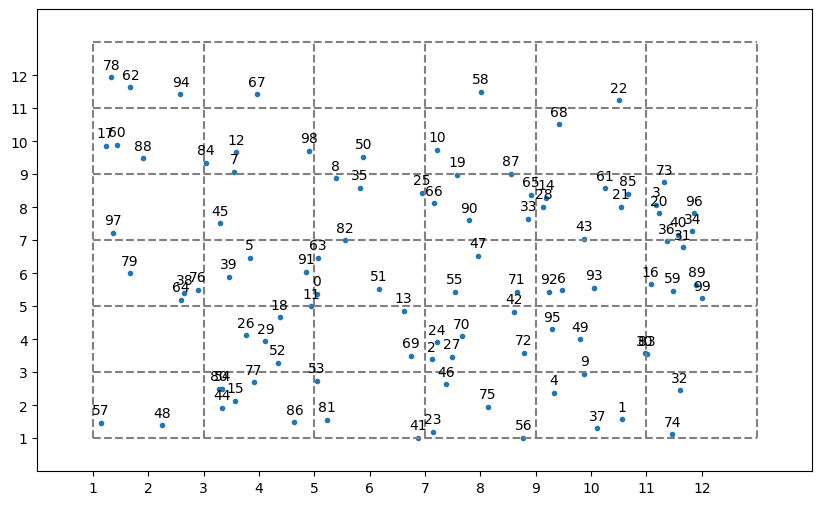

In [5]:
ticks = [val for val in range(l_bound, u_bound + 1)]
plt.figure(figsize=(10, 6))
plt.scatter(particle_pos.T[0], particle_pos.T[1], marker='.')
for idx, pos, _, _ in particle_matrix:
    plt.annotate(idx, (pos[0], pos[1]), textcoords="offset points", xytext=(0,6), ha='center')
boundaries = []
cumulative_sum = l_bound
for _ in range(l_bound, u_bound + cell_side, cell_side):
    boundaries.append(cumulative_sum) 
    cumulative_sum += cell_side  # Add the step value to the cumulative sum
plt.hlines(boundaries, xmin=l_bound, xmax=max(boundaries), colors="grey", linestyles="--")
plt.vlines(boundaries, ymin=l_bound, ymax=max(boundaries), colors="grey", linestyles="--")
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlim(l_bound - 1, max(boundaries) + 1)
plt.ylim(l_bound - 1, max(boundaries) + 1)


In [6]:
# %%writefile -a exercise5.py

def get_neighbors_2d(cell_list, particle_matrix, num_cells):
    neighbors = [[] for _ in range(len(particle_matrix))]
    
    for i, _, cell_x, cell_y in particle_matrix:
        neighbor_cells = []
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if 0 <= cell_x + dx < num_cells and 0 <= cell_y + dy < num_cells:
                    neighbor_cells.append((cell_x + dx) * num_cells + (cell_y + dy))
        # Collect the particle indices from the neighboring cells
        for cell_index in neighbor_cells:
            for neighbor_index in cell_list[cell_index]:
                if neighbor_index != i:
                    neighbors[i].append(neighbor_index)
    
    return neighbors

def get_neighbors_1d(cell_list, particle_matrix, num_cells):
    neighbors = [[] for _ in range(len(particle_matrix))]
    
    for i, _, cell in particle_matrix:
        neighbor_cells = []
        for dx in [-1, 0, 1]:
            if 0 <= cell + dx < num_cells:
                neighbor_cells.append(cell + dx)
        # Collect the particle indices from the neighboring cells
        for cell_index in neighbor_cells:
            for neighbor_index in cell_list[cell_index]:
                if neighbor_index != i:
                    neighbors[i].append(neighbor_index)
    
    return neighbors

In [7]:
# %%writefile -a exercise5.py

def distance_2d(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def distance_1d(pos1, pos2):
    return pos1 - pos2

In [8]:
# %%writefile -a exercise5.py

def get_verlet_list_2d(cell_list, particle_matrix, num_cells, cutoff):
    cell_neighbours = get_neighbors_2d(cell_list, particle_matrix, num_cells)
    verlet = [[] for _ in range(len(particle_matrix))]
    for cell, neighbourhood in enumerate(cell_neighbours):
        for neighbour in neighbourhood:
            if distance_2d(particle_matrix[cell][1], particle_matrix[neighbour][1]) <= cutoff:
                verlet[cell].append(neighbour)
    return verlet


def get_verlet_list_1d(cell_list, particle_matrix, num_cells, cutoff):
    cell_neighbours = get_neighbors_1d(cell_list, particle_matrix, num_cells)
    verlet = [[] for _ in range(len(particle_matrix))]
    for cell, neighbourhood in enumerate(cell_neighbours):
        for neighbour in neighbourhood:
            if distance_1d(particle_matrix[cell][1], particle_matrix[neighbour][1]) <= cutoff:
                verlet[cell].append(neighbour)
    return verlet

In [9]:
cutoff = cell_side
verlet = get_verlet_list_2d(cell_list, particle_matrix, num_cells, cutoff)
print("Verlet List: ", verlet)

Verlet List:  [[11, 18, 26, 29, 5, 39, 91, 13, 51, 63, 82], [56, 4, 9, 37, 32, 74], [13, 69, 46, 75, 24, 27, 70, 72], [14, 21, 43, 61, 85, 31, 36, 20, 34, 40, 73, 96], [46, 56, 75, 72, 1, 9, 37, 49, 95], [38, 64, 76, 11, 18, 39, 91, 45, 0, 63, 82], [42, 47, 55, 71, 49, 95, 92, 93, 43, 16], [88, 45, 12, 84, 98, 8], [7, 12, 98, 25, 35, 82, 50, 66], [72, 1, 4, 37, 30, 49, 95, 32, 83], [25, 35, 50, 19, 66, 87, 58], [18, 26, 29, 52, 5, 39, 91, 13, 0, 51, 63], [88, 7, 84, 98, 67, 8], [11, 69, 0, 51, 2, 24, 27, 42, 70, 55], [19, 33, 65, 90, 87, 21, 28, 43, 61, 85, 3], [48, 44, 54, 77, 80, 86, 26, 29, 52, 53, 81], [6, 92, 93, 43, 31, 36, 59, 89, 99, 34, 40], [60, 88, 62, 84], [38, 64, 76, 11, 26, 29, 52, 5, 39, 91, 0, 51, 63], [25, 35, 50, 33, 65, 66, 90, 10, 87, 14, 28], [21, 43, 61, 85, 31, 36, 3, 34, 40, 73, 96], [33, 65, 14, 28, 43, 61, 85, 31, 36, 3, 20, 34, 40, 73, 96], [68], [41, 81, 46, 56, 75], [13, 69, 51, 46, 2, 27, 42, 70, 72, 55], [8, 35, 82, 50, 19, 65, 66, 90, 10, 87], [38, 64, 

In [20]:
l_bound = 0
u_bound = 1
cell_side = 0.05
N = 10000
particle_pos = np.array(np.random.uniform(l_bound, u_bound, size = (N, 2)))
particle_matrix, cell_list, num_cells = get_cell_list_2d(particle_pos, l_bound, u_bound, cell_side)
verlet = get_verlet_list_2d(cell_list, particle_matrix, num_cells, cutoff)

In [21]:
highlighted_cell = np.random.randint(0, num_cells**2)
print(highlighted_cell)

363


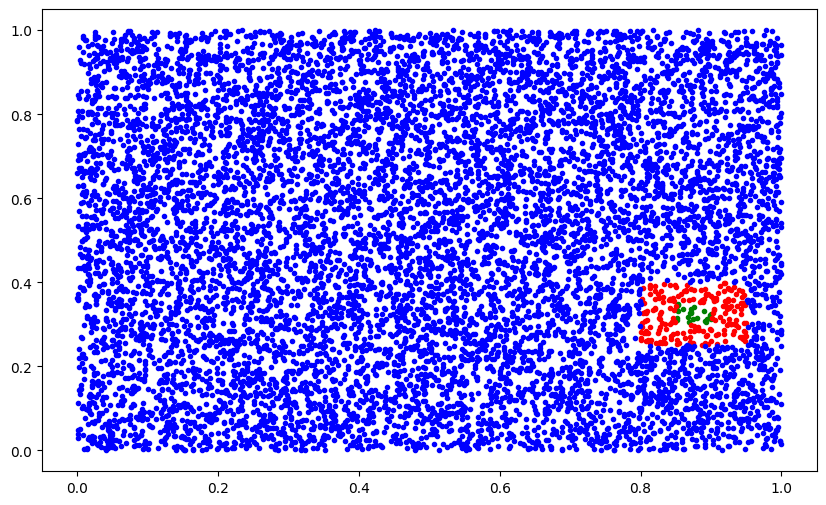

In [22]:
plt.figure(figsize=(10, 6))

verlet_particle = np.random.choice(cell_list[highlighted_cell]) 

red_points_x = []
red_points_y = []
highlighted_x = []
highlighted_y = []
normal_x = []
normal_y = []

for i, cell in enumerate(cell_list):
    for neighborhood in cell:
        x, y = particle_matrix[neighborhood][1]
        if neighborhood in verlet[verlet_particle] and i != highlighted_cell:
            red_points_x.append(x)
            red_points_y.append(y)
        elif i == highlighted_cell:
            highlighted_x.append(x)
            highlighted_y.append(y)
        else:
            normal_x.append(x)
            normal_y.append(y)

plt.scatter(highlighted_x, highlighted_y, marker='.', color='g')
plt.scatter(red_points_x, red_points_y, marker='.', color='red')
plt.scatter(normal_x, normal_y, marker='.', color='b')

plt.show()


In [23]:
print(verlet[verlet_particle])
print(cell_list[highlighted_cell])

dif = set(verlet[verlet_particle]).difference(set(cell_list[highlighted_cell]))
print(dif)
print(len(dif))

[620, 895, 947, 1213, 1339, 1343, 1369, 1886, 2057, 2394, 2650, 2869, 2955, 3047, 3052, 3088, 3211, 3566, 3619, 5432, 5665, 6674, 7234, 7779, 8038, 8728, 8877, 9795, 250, 922, 937, 967, 1298, 1920, 2717, 2956, 3797, 4448, 4498, 4565, 4858, 5669, 5826, 6238, 6665, 7202, 7296, 7402, 7962, 8595, 8738, 8914, 9136, 9782, 1175, 1305, 1884, 2200, 2668, 2987, 4446, 4542, 4766, 4978, 5038, 5761, 6689, 6942, 7058, 7565, 7718, 7738, 8621, 8975, 9098, 9399, 9745, 9746, 9847, 363, 1018, 1332, 2146, 2553, 2713, 2766, 4213, 4442, 4465, 4531, 5477, 5552, 5618, 6152, 7021, 7443, 7524, 7681, 7976, 8170, 8498, 8551, 8625, 9214, 626, 1174, 1703, 2169, 2982, 3081, 3798, 3888, 3993, 4171, 4458, 5365, 5544, 6118, 6924, 7122, 7277, 7476, 7659, 7922, 8086, 8771, 9373, 470, 1362, 1933, 2500, 3902, 4729, 4814, 4855, 5442, 5703, 5755, 5963, 6392, 6545, 6592, 7318, 7347, 7527, 7628, 8333, 8569, 8681, 9408, 767, 1711, 1752, 2132, 2471, 2572, 3800, 4195, 4915, 5045, 5819, 6030, 7359, 7668, 8369, 9050, 9181, 9825, 99

In [24]:
file_path = 'QSBacterialPos.dat'
particle_pos = np.array(pd.read_csv(file_path, delim_whitespace=True, header=None))
print(particle_pos)

[[5.0462363  3.8610672 ]
 [1.0486823  6.2845509 ]
 [9.5706173  9.3909751 ]
 ...
 [3.7574181  1.3107795 ]
 [0.23341919 0.67758386]
 [6.7263376  9.7026409 ]]


C:\Users\79217\AppData\Local\Temp\ipykernel_8260\1408595989.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  particle_pos = np.array(pd.read_csv(file_path, delim_whitespace=True, header=None))


In [25]:
cell_side = cutoff = 0.5
l_bound = 0
u_bound = 10
particle_matrix, cell_list, num_cells = get_cell_list_2d(particle_pos, l_bound, u_bound, cell_side)
verlet = get_verlet_list_2d(cell_list, particle_matrix, num_cells, cutoff)

In [26]:
cell_x, cell_y = [], []

for cell in cell_list:
    if len(cell) >= 20:
        cell_x.extend(particle_matrix[neighborhood][1][0] for neighborhood in cell)
        cell_y.extend(particle_matrix[neighborhood][1][1] for neighborhood in cell)

(-1.0, 11.0)

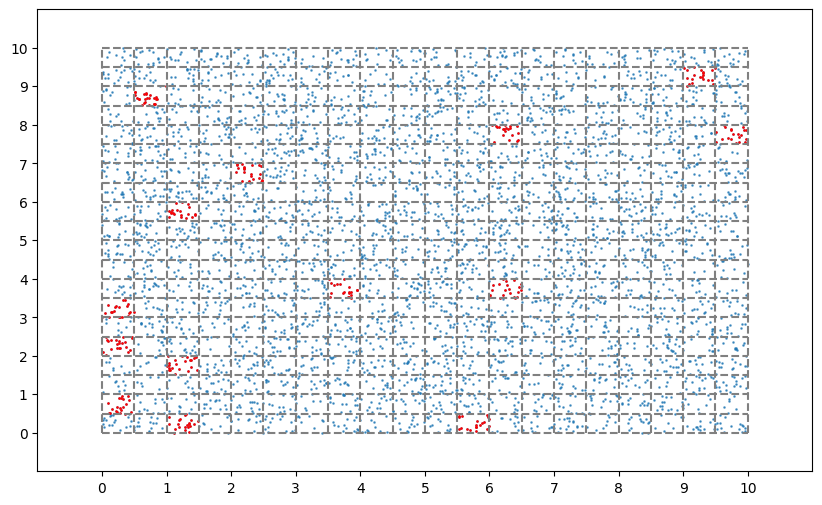

In [27]:
ticks = [val for val in range(l_bound, u_bound + 1)]
plt.figure(figsize=(10, 6))
plt.scatter(particle_pos.T[0], particle_pos.T[1], marker='.', alpha=0.7, s=3)
plt.scatter(cell_x, cell_y, color="red", marker=".", s=3)
boundaries = []
cumulative_sum = l_bound
for _ in np.arange(l_bound, u_bound + cell_side, cell_side):
    boundaries.append(cumulative_sum) 
    cumulative_sum += cell_side  # Add the step value to the cumulative sum
plt.hlines(boundaries, xmin=l_bound, xmax=max(boundaries), colors="grey", linestyles="--")
plt.vlines(boundaries, ymin=l_bound, ymax=max(boundaries), colors="grey", linestyles="--")
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlim(l_bound - 1, max(boundaries) + 1)
plt.ylim(l_bound - 1, max(boundaries) + 1)

In [28]:
neighbours_x, neighbours_y = [], []
centers_x, centers_y = [], []

for i, neighborhood in enumerate(verlet):
    if len(neighborhood) >= 50:
        centers_x.append(particle_matrix[i][1][0])
        centers_y.append(particle_matrix[i][1][1])
        neighbours_x.extend(particle_matrix[n][1][0] for n in neighborhood)
        neighbours_y.extend(particle_matrix[n][1][1] for n in neighborhood)

(-1.0, 11.0)

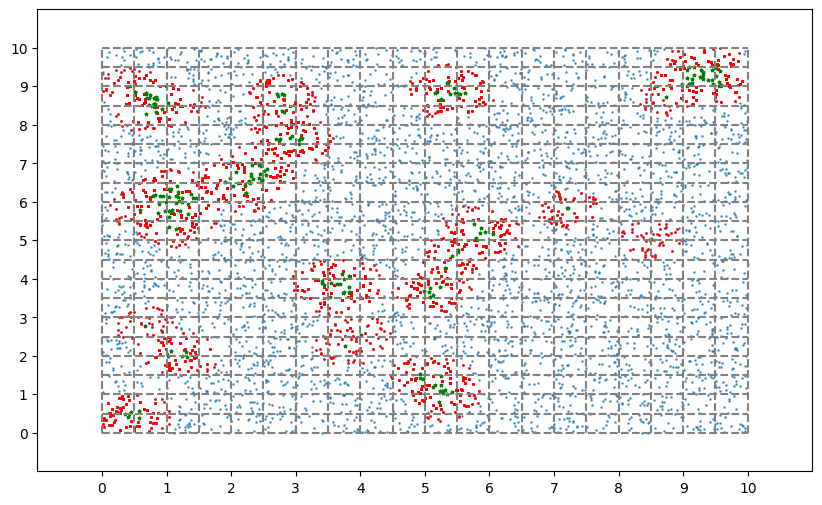

In [29]:
ticks = [val for val in range(l_bound, u_bound + 1)]
plt.figure(figsize=(10, 6))
plt.scatter(particle_pos.T[0], particle_pos.T[1], marker='.', alpha=0.7, s=3)
plt.scatter(neighbours_x, neighbours_y, color="red", marker=".", s=3)
plt.scatter(centers_x, centers_y, color="green", marker="*", s=5)
boundaries = []
cumulative_sum = l_bound
for _ in np.arange(l_bound, u_bound + cell_side, cell_side):
    boundaries.append(cumulative_sum) 
    cumulative_sum += cell_side  # Add the step value to the cumulative sum
plt.hlines(boundaries, xmin=l_bound, xmax=max(boundaries), colors="grey", linestyles="--")
plt.vlines(boundaries, ymin=l_bound, ymax=max(boundaries), colors="grey", linestyles="--")
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlim(l_bound - 1, max(boundaries) + 1)
plt.ylim(l_bound - 1, max(boundaries) + 1)